In [1]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 5.3 MB/s eta 0:00:00


In [2]:
!pip install pymc==5.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.1/469.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from datetime import datetime
warnings.filterwarnings("ignore")
timezone = pytz.timezone('America/Chicago')
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from scipy.stats import probplot

import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import graphviz

In [4]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw19.csv')
raw19 = raw19.loc[raw19['type'] == 'X']

raw23 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

Mounted at /drive


In [5]:
#combine
all_data = pd.concat((raw23, raw22, raw21, raw20, raw19))

del raw22
del raw21
del raw20
del raw23
del raw19

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#define hit direction type
all_data['is_oppo'] = 0
all_data.loc[all_data.hit_direction > 0, 'is_oppo'] = 1
all_data['is_pull'] = 1-all_data.is_oppo.values

#launch angle type
all_data['la_type'] = 0 #gb
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <= 25), 'la_type'] = 1 #ld
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <= 50), 'la_type'] = 2 #fb
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3 #pu
all_data['is_gb'] = 0
all_data['is_ld'] = 0
all_data['is_fb'] = 0
all_data['is_pu'] = 0
all_data.loc[all_data.la_type == 0, 'is_gb'] = 1
all_data.loc[all_data.la_type == 1, 'is_ld'] = 1
all_data.loc[all_data.la_type == 2, 'is_fb'] = 1
all_data.loc[all_data.la_type == 3, 'is_pu'] = 1

#max ev minus ev
max_ev = 123.
all_data['ev2'] = max_ev - all_data.launch_speed.values

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR', 'x', 'y', 'hit_direction', 'hd', 'is_oppo', 'is_pull', 'la_type', 'is_gb',
                     'is_ld', 'is_fb', 'is_pu', 'ev2']]

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(all_data.batter_id_hand.unique())})
batter_indices['batter_index'] = batter_indices.index.values
train = all_data.merge(batter_indices, on = 'batter_id_hand')

### Launch Speed

In [6]:
max_ev

123.0

In [7]:
#estimates for the priors
alphas = []
scales = []
hittypes = []
for b in batter_indices.batter_index.values:
    d = train.loc[train.batter_index == b]
    for ht in range(4):
        dt = d.loc[d.la_type == ht]
        if dt.shape[0] < 20:
            continue
        #use mle to get alpha and scale
        try:
          a, _, scale = gamma.fit(dt.ev2.values, floc = 0)
        except:
          continue
        alphas.append(a)
        scales.append(scale)
        hittypes.append(ht)
hitter_info = pd.DataFrame({'la_type': hittypes, 'alpha': alphas, 'scale': scales})

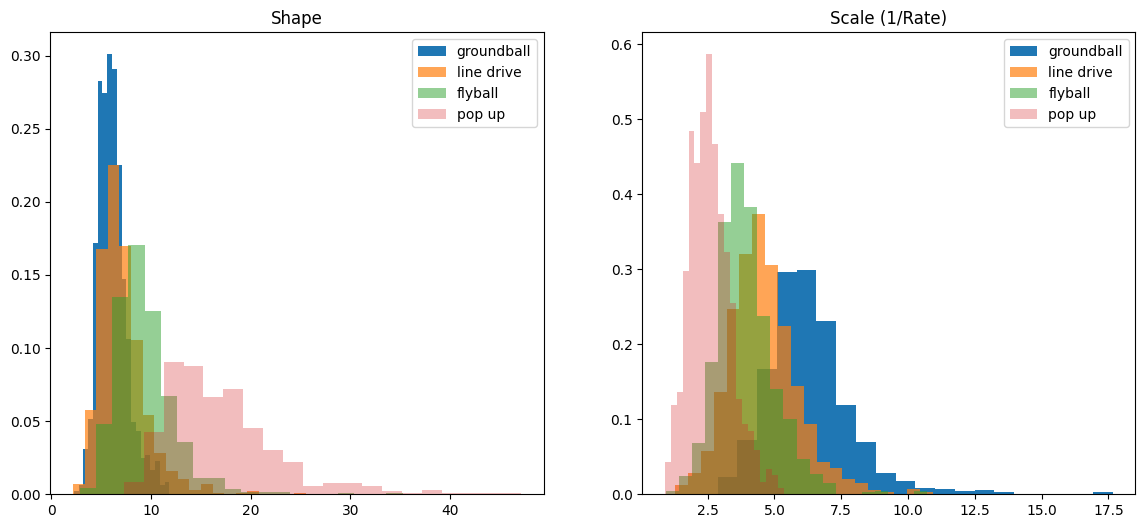

In [8]:
plt.figure(figsize = (14,6))
ax1 = plt.subplot(121)
ax1.hist(hitter_info.loc[hitter_info.la_type == 0].alpha.values, density = True, bins = 20, label = 'groundball')
ax1.hist(hitter_info.loc[hitter_info.la_type == 1].alpha.values, density = True, bins = 20, alpha = 0.7, label = 'line drive')
ax1.hist(hitter_info.loc[hitter_info.la_type == 2].alpha.values, density = True, bins = 20, alpha = 0.5, label = 'flyball')
ax1.hist(hitter_info.loc[hitter_info.la_type == 3].alpha.values, density = True, bins = 20, alpha = 0.3, label = 'pop up')
ax1.set_title('Shape')
ax1.legend()
ax2 = plt.subplot(122)
ax2.hist(hitter_info.loc[hitter_info.la_type == 0].scale.values, density = True, bins = 20, label = 'groundball')
ax2.hist(hitter_info.loc[hitter_info.la_type == 1].scale.values, density = True, bins = 20, alpha = 0.7, label = 'line drive')
ax2.hist(hitter_info.loc[hitter_info.la_type == 2].scale.values, density = True, bins = 20, alpha = 0.5, label = 'flyball')
ax2.hist(hitter_info.loc[hitter_info.la_type == 3].scale.values, density = True, bins = 20, alpha = 0.3, label = 'pop up')
ax2.set_title('Scale (1/Rate)')
ax2.legend()
plt.show()

In [ ]:
alpha_means = np.array([hitter_info.loc[hitter_info.la_type == 0].alpha.mean(),hitter_info.loc[hitter_info.la_type == 1].alpha.mean(),hitter_info.loc[hitter_info.la_type == 2].alpha.mean(),hitter_info.loc[hitter_info.la_type == 3].alpha.mean()])
alpha_stds = np.array([hitter_info.loc[hitter_info.la_type == 0].alpha.std(),hitter_info.loc[hitter_info.la_type == 1].alpha.std(),hitter_info.loc[hitter_info.la_type == 2].alpha.std(),hitter_info.loc[hitter_info.la_type == 3].alpha.std()])

scale_means = np.array([hitter_info.loc[hitter_info.la_type == 0].scale.mean(),hitter_info.loc[hitter_info.la_type == 1].scale.mean(),hitter_info.loc[hitter_info.la_type == 2].scale.mean(),hitter_info.loc[hitter_info.la_type == 3].scale.mean()])
scale_stds = np.array([hitter_info.loc[hitter_info.la_type == 0].scale.std(),hitter_info.loc[hitter_info.la_type == 1].scale.std(),hitter_info.loc[hitter_info.la_type == 2].scale.std(),hitter_info.loc[hitter_info.la_type == 3].scale.std()])

In [ ]:
#fit the model
n_batters = len(train.batter_index.unique())
coords = {'batter': batter_indices.batter_index.values, 'observation': np.arange(train.shape[0]), 'hit_type': [0,1,2,3]} # hit type corresponds to the launch angle type

with pm.Model(coords = coords) as mod1:
    #the alpha values are batter specific and they have gamma priors
    batteralphas = pm.Gamma('batteralphas', mu = alpha_means, sigma = alpha_stds, dims = ('batter', 'hit_type'))

    #the scale values are batter specific and have gamma priors
    batterscales = pm.Gamma('batterscales', mu = scale_means, sigma = scale_stds, dims = ('batter', 'hit_type'))

    #likelihoods are gamma distributed, one for each launch angle type
    ht = pm.Data('ht', train.la_type.values, dims = 'observation')
    b = pm.Data('b', train.batter_index.values, dims = 'observation')
    x = pm.Data('x', train.ev2.values, dims = 'observation')
    likelihood = pm.Gamma('likelihood', alpha = batteralphas[b, ht], beta = 1/batterscales[b,ht],  observed = x, dims = 'observation')

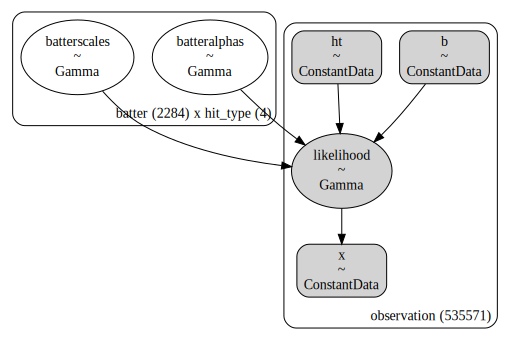

In [ ]:
graph = pm.model_to_graphviz(mod1)
graph

In [ ]:
with mod1:
    trace = pmjax.sample_numpyro_nuts(2000,chains=1, random_seed=42)

Compiling...
Compilation time =  0:00:03.318551
Sampling...


sample: 100%|██████████| 3000/3000 [20:27<00:00,  2.44it/s, 127 steps of size 3.80e-02. acc. prob=0.85]


Sampling time =  0:20:28.328045
Transforming variables...
Transformation time =  0:00:00.128759


In [ ]:
final_indices = batter_indices.copy()

In [ ]:
balphas = trace.posterior.batteralphas.mean(dim = ('draw', 'chain')).to_numpy()
final_indices[['batter_a_gb', 'batter_a_ld', 'batter_a_fb', 'batter_a_pu']] = balphas

bscales = trace.posterior.batterscales.mean(dim = ('draw', 'chain')).to_numpy()
final_indices[['batter_s_gb', 'batter_s_ld', 'batter_s_fb', 'batter_s_pu']] = bscales

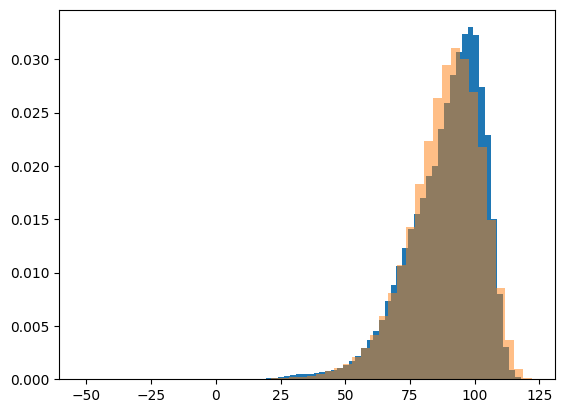

In [ ]:
#sanity check
t = train.merge(final_indices[['batter_index', 'batter_a_gb', 'batter_a_ld', 'batter_a_fb', 'batter_a_pu', 'batter_s_gb', 'batter_s_ld', 'batter_s_fb', 'batter_s_pu']], on = 'batter_index')
samp = t.is_gb.values * gamma(a = t.batter_a_gb.values, scale = t.batter_s_gb.values).rvs() + t.is_ld.values * gamma(a = t.batter_a_ld.values, scale = t.batter_s_ld.values).rvs() + t.is_fb.values * gamma(a = t.batter_a_fb.values, scale = t.batter_s_fb.values).rvs() + t.is_pu.values * gamma(a = t.batter_a_pu.values, scale = t.batter_s_pu.values).rvs()
plt.hist(t.launch_speed.values, density = True, bins = 50)
plt.hist(123-samp, density = True, bins = 50, alpha = 0.5)
plt.show()

### Hit Launch Angle

In [ ]:
#get a prior for the hitter average launch angle
hitter_avgs = train.groupby(['batter_index', 'is_pull', 'is_oppo'], as_index = False).agg(N = ('launch_angle', 'count'),la = ('launch_angle', 'mean'))
#make sure we have a reasonable sample size
hitter_avgs = hitter_avgs.loc[hitter_avgs.N >= 50]
hitter_avgs.loc[hitter_avgs.is_pull == 1].la.mean(), hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.mean(), hitter_avgs.loc[hitter_avgs.is_pull == 1].la.std(), hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.std()

(5.01464164057165, 20.686845043465706, 4.78685179143734, 5.033540352084173)

In [ ]:
hitter_stds = train.groupby(['batter_index', 'is_pull', 'is_oppo'], as_index = False).agg(n = ('launch_angle', 'count'),la = ('launch_angle', 'std'))
hitter_stds = hitter_stds.loc[hitter_stds.n >= 50]
a1,_, scale1 = gamma.fit(hitter_stds.loc[hitter_stds.is_pull == 1].la.values, floc = 0)
a2,_, scale2 = gamma.fit(hitter_stds.loc[hitter_stds.is_oppo == 1].la.values, floc = 0)

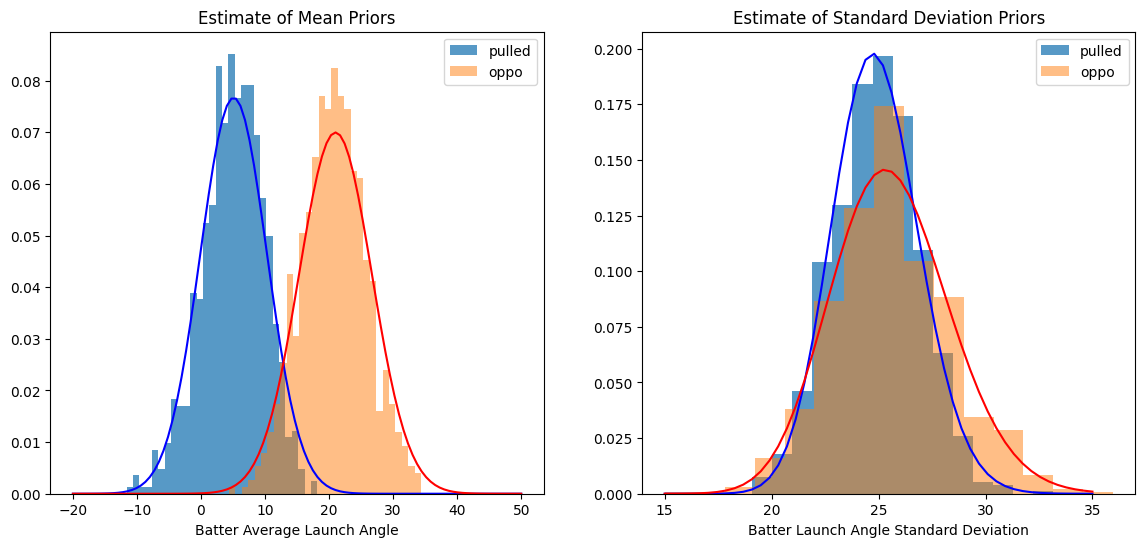

In [ ]:
x = np.linspace(-20,50,100)
plt.figure(figsize=(14,6))
ax1 = plt.subplot(121)
ax1.hist(hitter_avgs.loc[hitter_avgs.is_pull == 1].la.values, density = True, bins = 30, label = 'pulled', alpha = 0.75)
ax1.plot(x, norm(loc = 5.1, scale = 5.2).pdf(x), 'b-')
ax1.hist(hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax1.plot(x, norm(loc = 21, scale = 5.7).pdf(x), 'r-')
ax1.set_title('Estimate of Mean Priors')
ax1.set_xlabel('Batter Average Launch Angle')
ax1.legend()

x = np.linspace(15, 35)
ax2 = plt.subplot(122)
ax2.hist(hitter_stds.loc[hitter_stds.is_pull == 1].la.values, density = True, bins = 15, label = 'pulled', alpha = 0.75)
ax2.plot(x, gamma(a = a1, scale = scale1).pdf(x), 'b-')
ax2.hist(hitter_stds.loc[hitter_stds.is_oppo == 1].la.values, density = True, bins = 15, label = 'oppo', alpha = 0.5)
ax2.plot(x, gamma(a = a2, scale = scale2).pdf(x), 'r-')
ax2.set_title('Estimate of Standard Deviation Priors')
ax2.legend()
ax2.set_xlabel('Batter Launch Angle Standard Deviation')
plt.show()

In [ ]:
#build the model
n_batters = len(train.batter_index.unique())
coords = {'batter': batter_indices.batter_index.values, 'observation': np.arange(train.shape[0]), 'hit_type': [0,1]} #hit type corresponds to is_oppo in this case
#define the prior for the batter means
langle_means = np.array([hitter_avgs.loc[hitter_avgs.is_pull == 1].la.mean(), hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.mean()])
langle_sigma = np.array([hitter_avgs.loc[hitter_avgs.is_pull == 1].la.std(), hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.std()])
alpha_prior = np.array([a1, a2])
beta_prior = np.array([1/scale1, 1/scale2])

with pm.Model(coords = coords) as mod1:
    #the batter means have normal priors
    battermeans = pm.Normal('battermeans', mu = langle_means, sigma = langle_sigma, dims = ('batter', 'hit_type'))

    #the batter sigmas have gamma priors
    battersigmas = pm.Gamma('battersigmas', alpha = alpha_prior, beta = beta_prior, dims = ('batter', 'hit_type'))

    #the likelihoods are normally distributed based on if it's pull or oppo
    ht = pm.Data('ht', train.is_oppo.values, dims = 'observation')
    b = pm.Data('b', train.batter_index.values, dims = 'observation')
    x = pm.Data('x', train.launch_angle.values, dims = 'observation')
    likelihood = pm.Normal('likelihood', mu = battermeans[b, ht], sigma = battersigmas[b, ht], observed = x, dims = 'observation')

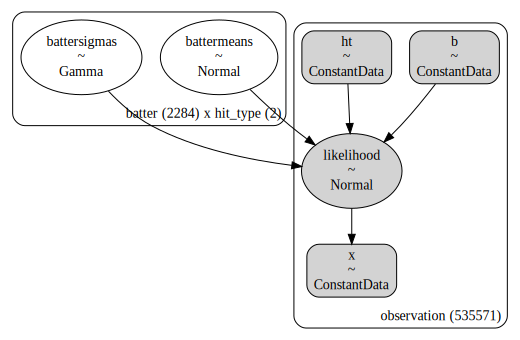

In [ ]:
graph = pm.model_to_graphviz(mod1)
graph

In [ ]:
with mod1:
    trace = pmjax.sample_numpyro_nuts(2000,chains=1, random_seed=42)

Compiling...
Compilation time =  0:00:10.520578
Sampling...


sample: 100%|██████████| 3000/3000 [03:45<00:00, 13.30it/s, 31 steps of size 1.35e-01. acc. prob=0.89]


Sampling time =  0:03:48.866400
Transforming variables...
Transformation time =  0:00:00.228973


In [ ]:
bmeans = trace.posterior.battermeans.mean(dim = ('draw', 'chain')).to_numpy()
final_indices[['batter_mean_pull', 'batter_mean_oppo']] = bmeans
bsigmas = trace.posterior.battersigmas.mean(dim = ('draw', 'chain')).to_numpy()
final_indices[['batter_sigma_pull', 'batter_sigma_oppo']] = bsigmas

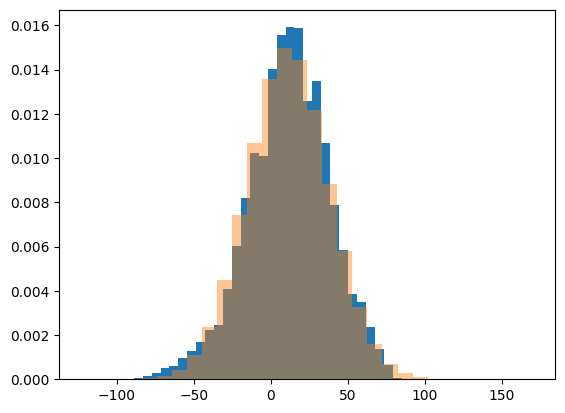

In [ ]:
#sanity check
t = train.merge(final_indices[['batter_index', 'batter_mean_pull', 'batter_sigma_pull',  'batter_mean_oppo', 'batter_sigma_oppo']], on = 'batter_index')
samp = t.is_oppo.values * norm(loc = t.batter_mean_oppo.values, scale = t.batter_sigma_oppo.values).rvs() + t.is_pull.values * norm(loc = t.batter_mean_pull.values, scale = t.batter_sigma_pull.values).rvs()
plt.hist(t.launch_angle.values, density = True, bins = 30)
plt.hist(samp, density = True, bins = 30, alpha = 0.45)
plt.show()

### Hit Direction

In [ ]:
n_batters = len(train.batter_index.unique())
nclusters = 2
coords = {'batter': batter_indices.batter_index.values, 'observation': np.arange(train.shape[0]), 'clusters': [1,2]}

with pm.Model(coords = coords) as mod1:

    ####hyperpriors
    #gamma dist for the prior for the alpha in the dirichlet distribution. Gamma will ensure that we don't get any nonpositive values
    weight_alpha_prior = pm.Gamma('weight_alpha_prior', mu = np.array([4,6]), sigma = np.array([10,10]))

    #gamma dist for the prior for the mean in the batter alphas and batter betas. This ensures positive means
    alpha_mu_prior = pm.Gamma('alpha_mu_prior', mu = np.array([3,3]), sigma = np.array([10,10]))
    beta_mu_prior = pm.Gamma('beta_mu_prior', mu = np.array([9,2]), sigma = np.array([10,10]))

    #half normals for the sigma priors
    alpha_sigma_prior = pm.HalfNormal('alpha_sigma_prior', sigma = np.ones(nclusters))
    beta_sigma_prior = pm.HalfNormal('beta_sigma_prior', sigma = np.ones(nclusters))

    #### batter specific beta dists
    #prior for the alpha parameter in the beta dists
    batteralphas = pm.Gamma('batteralphas', mu = alpha_mu_prior, sigma = alpha_sigma_prior, dims = ('batter', 'clusters'))

    #prior for the beta parameter in the beta dists
    batterbetas = pm.Gamma('batterbetas', mu = beta_mu_prior, sigma = beta_sigma_prior, dims = ('batter', 'clusters'))

    #the batter weights have a prior of dirichlet(alpha_prior)
    batterweights = pm.Dirichlet('batterweights', a = weight_alpha_prior, dims = ('batter', 'clusters'))

    b = pm.Data("b", train.batter_index.values, dims = 'observation')
    x = pm.Data('x', train.hd.values, dims = 'observation')

    #each observation is distributed as a mixture of betas with alpha given by batter_alphas, beta given by batterbetas, and weights given by the batter weights.
    bets = pm.Beta.dist(alpha = batteralphas[b], beta = batterbetas[b], shape = (train.shape[0],2))
    likelihood = pm.Mixture('likelihood', w= batterweights[b], comp_dists = bets, observed = x, dims = 'observation')

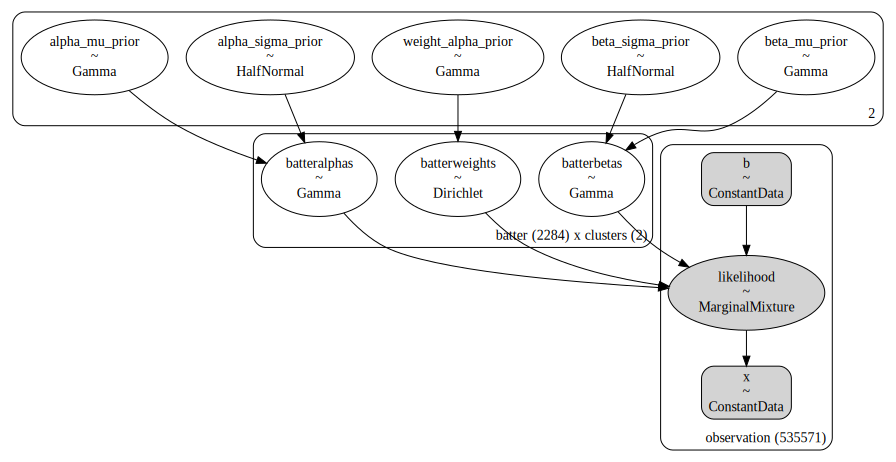

In [ ]:
graph = pm.model_to_graphviz(mod1)
graph

In [ ]:
with mod1:
    inference = pm.ADVI()
    approx = pm.fit(n=20000, method = inference)

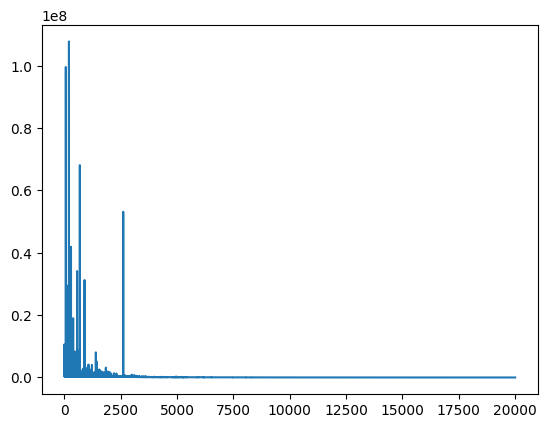

In [ ]:
plt.plot(inference.hist, label = 'advi')
plt.show()
trace = approx.sample(2000)

In [ ]:
balphas = trace.posterior.batteralphas.mean(dim = ('draw', 'chain')).to_numpy()
final_indices[['batter_alpha1', 'batter_alpha2']] = balphas
bbs = trace.posterior.batterbetas.mean(dim = ('draw', 'chain')).to_numpy()
final_indices[['batter_beta1', 'batter_beta2']] = bbs
bweights = trace.posterior.batterweights.mean(dim = ('draw', 'chain')).to_numpy()
final_indices[['batter_w1', 'batter_w2']] = bweights

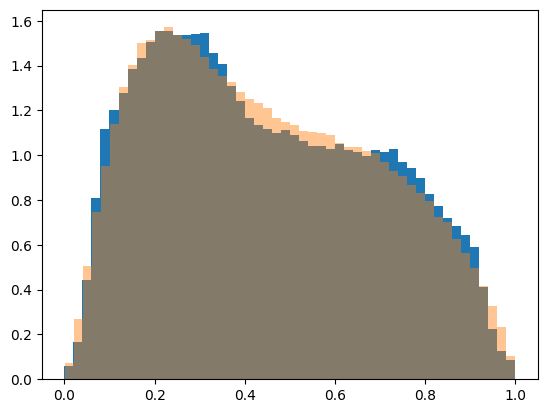

In [ ]:
#sanity check
t = train.merge(final_indices[['batter_index', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2']], on = 'batter_index')
choice = np.random.binomial(1, t.batter_w1.values, size = t.shape[0])
samp = choice * beta(a = t.batter_alpha1.values, b = t.batter_beta1.values).rvs() + (1-choice) * beta(a = t.batter_alpha2.values, b = t.batter_beta2.values).rvs()
plt.hist(t.hd.values, density = True, bins = 50)
plt.hist(samp, density = True, bins = 50, alpha = 0.45)
plt.show()

In [ ]:
final_indices.to_csv('/drive/My Drive/Colab Notebooks/positioning_project/hitter_distribution_estimates/final_dists.csv', index=False)

### Hitter plots

In [9]:
final_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/hitter_distribution_estimates/final_dists.csv')

In [10]:
lowe = final_indices.loc[final_indices.batter_id_hand == '663993-0']
gallo = final_indices.loc[final_indices.batter_id_hand == '608336-0']
chas = final_indices.loc[final_indices.batter_id_hand == '676801-1']
breg = final_indices.loc[final_indices.batter_id_hand == '608324-1']
yandy = final_indices.loc[final_indices.batter_id_hand == '650490-1']

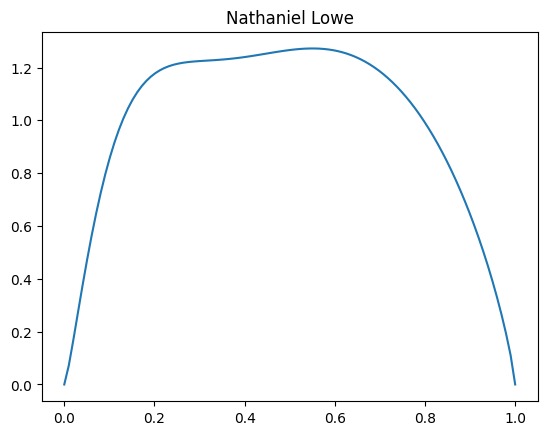

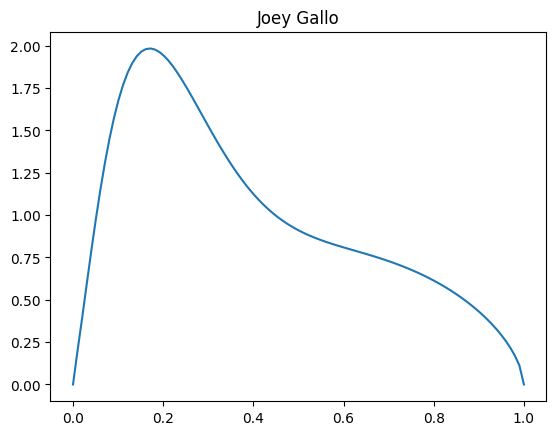

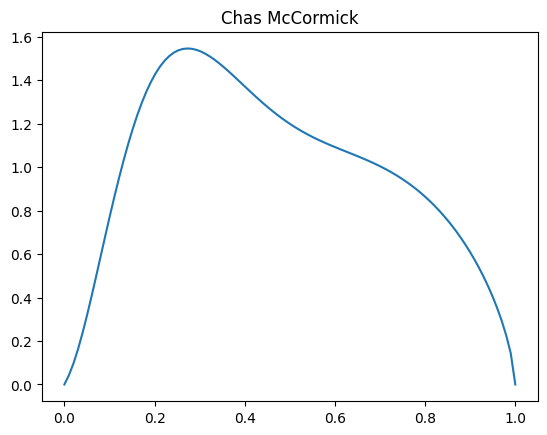

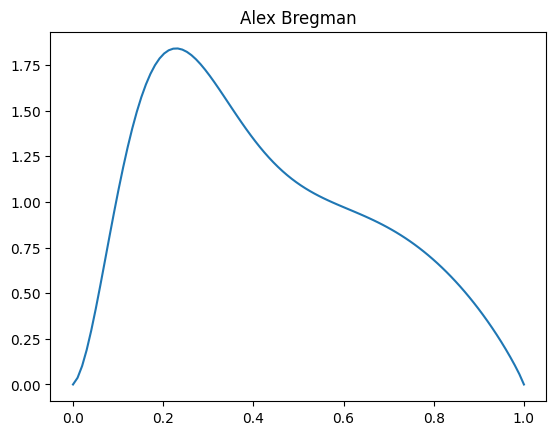

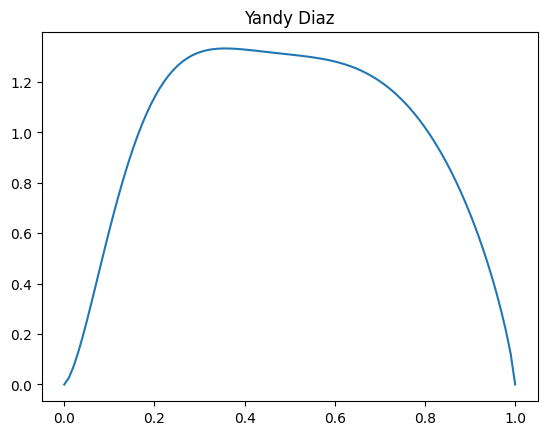

In [11]:
x = np.linspace(0,1,100)
plt.plot(x, lowe.batter_w1.values[0] * beta(a = lowe.batter_alpha1.values[0], b = lowe.batter_beta1.values[0]).pdf(x) + lowe.batter_w2.values[0] * beta(a = lowe.batter_alpha2.values[0], b = lowe.batter_beta2.values[0]).pdf(x), '-')
plt.title('Nathaniel Lowe')
plt.show()

plt.plot(x, gallo.batter_w1.values[0] * beta(a = gallo.batter_alpha1.values[0], b = gallo.batter_beta1.values[0]).pdf(x) + gallo.batter_w2.values[0] * beta(a = gallo.batter_alpha2.values[0], b = gallo.batter_beta2.values[0]).pdf(x), '-')
plt.title('Joey Gallo')
plt.show()

plt.plot(x, chas.batter_w1.values[0] * beta(a = chas.batter_alpha1.values[0], b = chas.batter_beta1.values[0]).pdf(x) + chas.batter_w2.values[0] * beta(a = chas.batter_alpha2.values[0], b = chas.batter_beta2.values[0]).pdf(x), '-')
plt.title('Chas McCormick')
plt.show()

plt.plot(x, breg.batter_w1.values[0] * beta(a = breg.batter_alpha1.values[0], b = breg.batter_beta1.values[0]).pdf(x) +breg.batter_w2.values[0] * beta(a = breg.batter_alpha2.values[0], b = breg.batter_beta2.values[0]).pdf(x), '-')
plt.title('Alex Bregman')
plt.show()

plt.plot(x, yandy.batter_w1.values[0] * beta(a = yandy.batter_alpha1.values[0], b = yandy.batter_beta1.values[0]).pdf(x) + yandy.batter_w2.values[0] * beta(a = yandy.batter_alpha2.values[0], b = yandy.batter_beta2.values[0]).pdf(x), '-')
plt.title('Yandy Diaz')
plt.show()

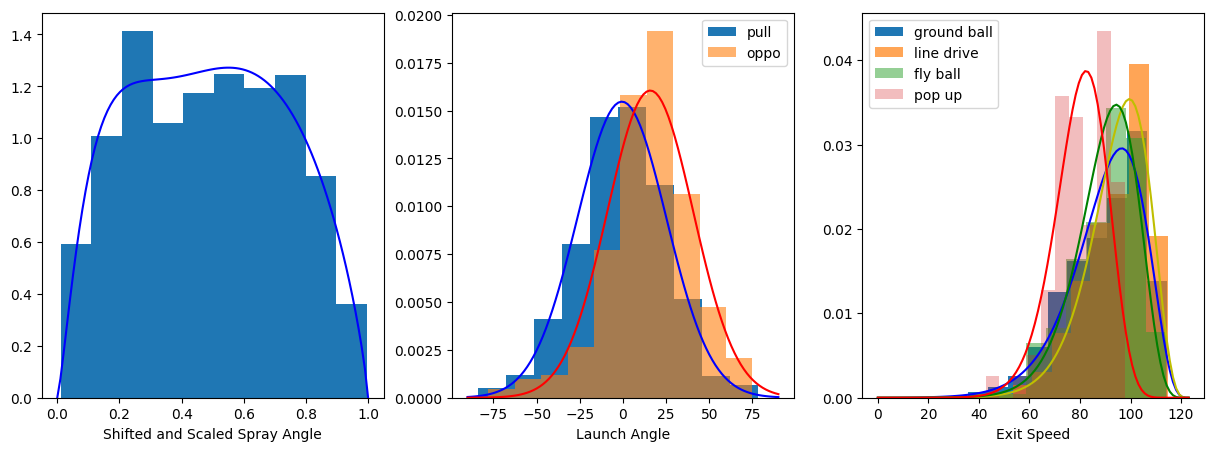

In [18]:
low2= train.loc[train.batter == 663993]
x = np.linspace(0,1,100)
plt.figure(figsize = ((15,5)))
ax1 = plt.subplot(131)
ax1.hist(low2.hd.values, density = True)
ax1.plot(x, lowe.batter_w1.values[0] * beta(a = lowe.batter_alpha1.values[0], b = lowe.batter_beta1.values[0]).pdf(x) + lowe.batter_w2.values[0] * beta(a = lowe.batter_alpha2.values[0], b = lowe.batter_beta2.values[0]).pdf(x), 'b-')
ax1.set_xlabel('Shifted and Scaled Spray Angle')

x = np.linspace(-90,90,100)
ax2 = plt.subplot(132)
ax2.hist(low2.loc[low2.is_pull == 1].launch_angle.values, density = True, label = 'pull')
ax2.hist(low2.loc[low2.is_pull == 0].launch_angle.values, density = True, label = 'oppo', alpha = 0.6)
ax2.plot(x, norm(loc = lowe.batter_mean_pull.values[0], scale = lowe.batter_sigma_pull.values[0]).pdf(x), 'b-')
ax2.plot(x, norm(loc = lowe.batter_mean_oppo.values[0], scale = lowe.batter_sigma_oppo.values[0]).pdf(x), 'r-')
ax2.legend()
ax2.set_xlabel('Launch Angle')

x = np.linspace(0,max_ev,100)
ax3 = plt.subplot(133)
ax3.hist(low2.loc[low2.is_gb == 1].launch_speed.values, density = True, label = 'ground ball')
ax3.hist(low2.loc[low2.is_ld == 1].launch_speed.values, density = True, label = 'line drive', alpha = 0.7)
ax3.hist(low2.loc[low2.is_fb == 1].launch_speed.values, density = True, label = 'fly ball', alpha = 0.5)
ax3.hist(low2.loc[low2.is_pu == 1].launch_speed.values, density = True, label = 'pop up', alpha = 0.3)
ax3.plot(x, gamma(a = lowe.batter_a_gb.values[0], scale = lowe.batter_s_gb.values[0]).pdf(max_ev - x), 'b-')
ax3.plot(x, gamma(a = lowe.batter_a_ld.values[0], scale = lowe.batter_s_ld.values[0]).pdf(max_ev - x), 'y-')
ax3.plot(x, gamma(a = lowe.batter_a_fb.values[0], scale = lowe.batter_s_fb.values[0]).pdf(max_ev - x), 'g-')
ax3.plot(x, gamma(a = lowe.batter_a_pu.values[0], scale = lowe.batter_s_pu.values[0]).pdf(max_ev - x), 'r-')
ax3.legend()
ax3.set_xlabel('Exit Speed')
plt.show()

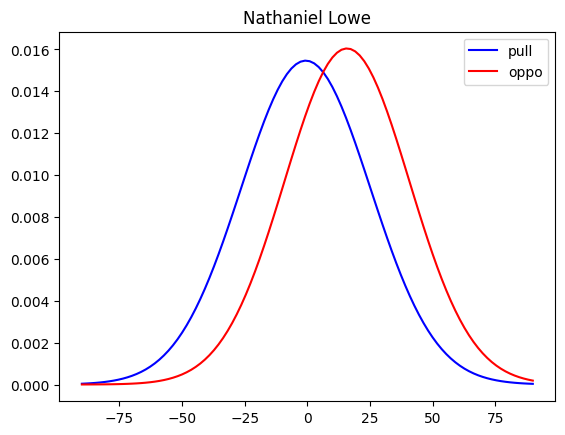

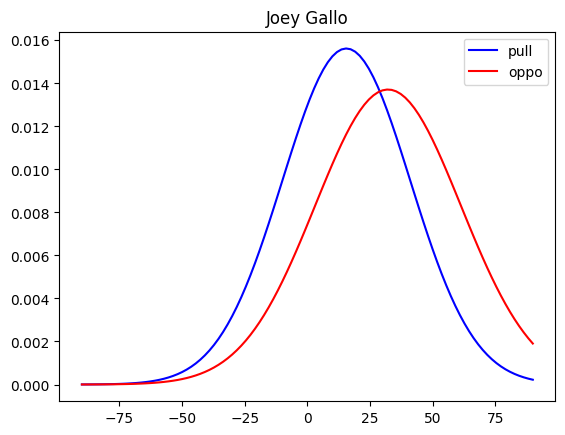

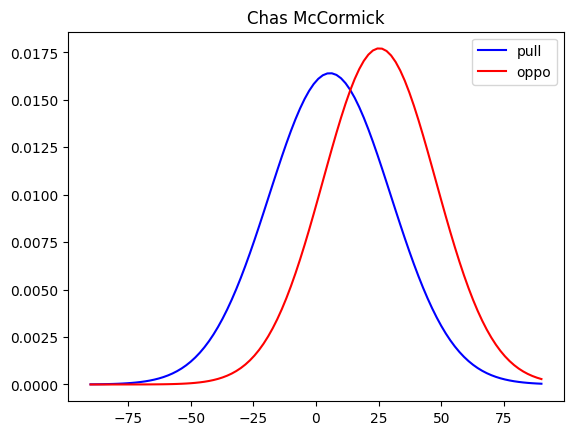

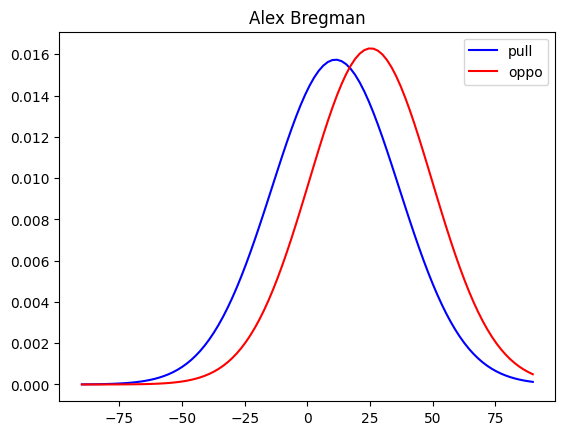

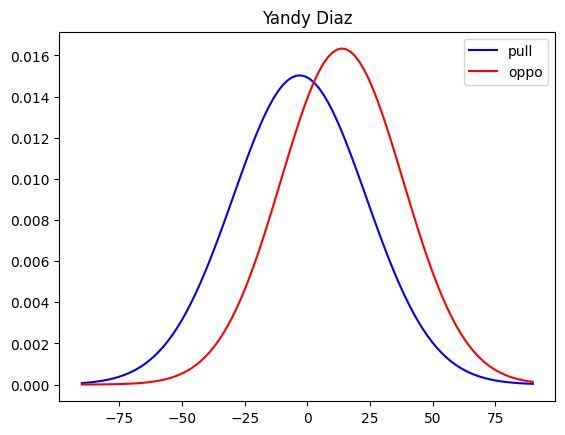

In [ ]:
x = np.linspace(-90,90,100)
plt.plot(x, norm(loc = lowe.batter_mean_pull.values[0], scale = lowe.batter_sigma_pull.values[0]).pdf(x), 'b-', label = 'pull')
plt.plot(x, norm(loc = lowe.batter_mean_oppo.values[0], scale = lowe.batter_sigma_oppo.values[0]).pdf(x), 'r-', label = 'oppo')
plt.title('Nathaniel Lowe')
plt.legend()
plt.show()

plt.plot(x, norm(loc = gallo.batter_mean_pull.values[0], scale = gallo.batter_sigma_pull.values[0]).pdf(x), 'b-', label = 'pull')
plt.plot(x, norm(loc = gallo.batter_mean_oppo.values[0], scale = gallo.batter_sigma_oppo.values[0]).pdf(x), 'r-', label = 'oppo')
plt.title('Joey Gallo')
plt.legend()
plt.show()

plt.plot(x, norm(loc = chas.batter_mean_pull.values[0], scale = chas.batter_sigma_pull.values[0]).pdf(x), 'b-', label = 'pull')
plt.plot(x, norm(loc = chas.batter_mean_oppo.values[0], scale = chas.batter_sigma_oppo.values[0]).pdf(x), 'r-', label = 'oppo')
plt.title('Chas McCormick')
plt.legend()
plt.show()

plt.plot(x, norm(loc = breg.batter_mean_pull.values[0], scale = breg.batter_sigma_pull.values[0]).pdf(x), 'b-', label = 'pull')
plt.plot(x, norm(loc = breg.batter_mean_oppo.values[0], scale = breg.batter_sigma_oppo.values[0]).pdf(x), 'r-', label = 'oppo')
plt.title('Alex Bregman')
plt.legend()
plt.show()

plt.plot(x, norm(loc = yandy.batter_mean_pull.values[0], scale = yandy.batter_sigma_pull.values[0]).pdf(x), 'b-', label = 'pull')
plt.plot(x, norm(loc = yandy.batter_mean_oppo.values[0], scale = yandy.batter_sigma_oppo.values[0]).pdf(x), 'r-', label = 'oppo')
plt.title('Yandy Diaz')
plt.legend()
plt.show()

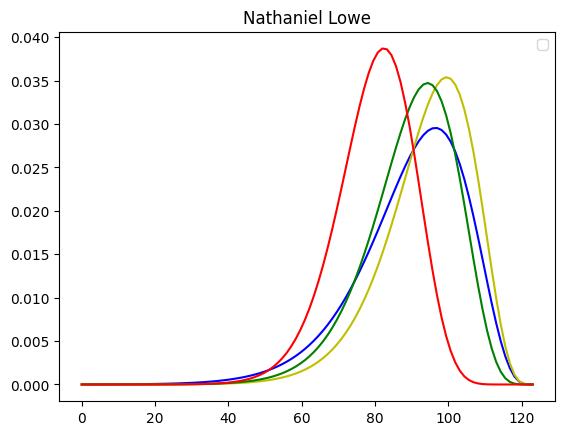

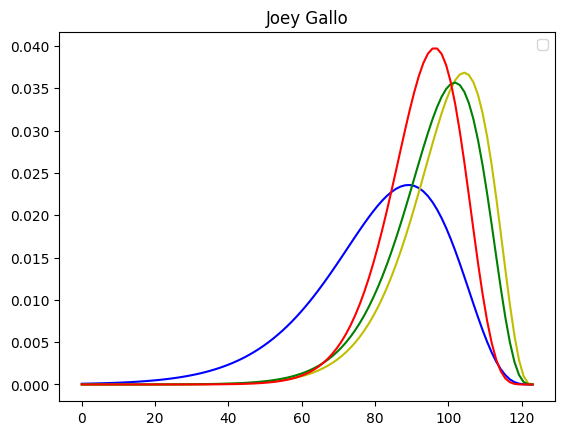

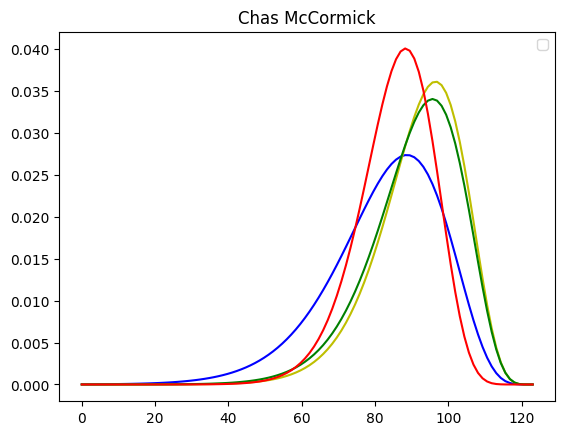

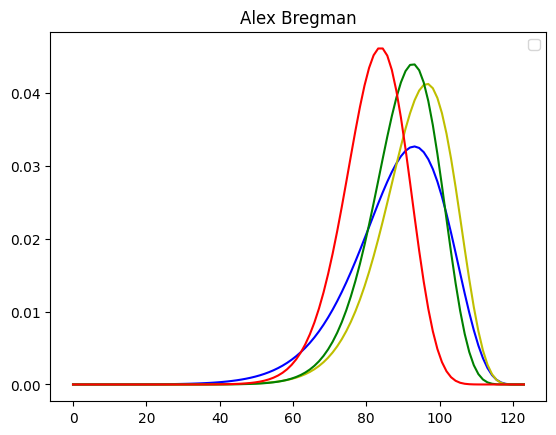

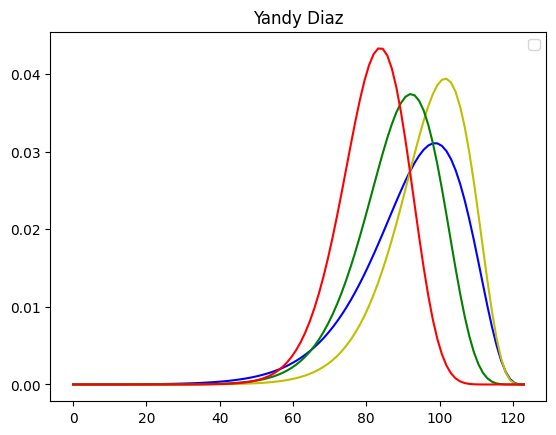

In [ ]:
x = np.linspace(0,max_ev,100)
plt.plot(x, gamma(a = lowe.batter_a_gb.values[0], scale = lowe.batter_s_gb.values[0]).pdf(max_ev - x), 'b-')
plt.plot(x, gamma(a = lowe.batter_a_ld.values[0], scale = lowe.batter_s_ld.values[0]).pdf(max_ev - x), 'y-')
plt.plot(x, gamma(a = lowe.batter_a_fb.values[0], scale = lowe.batter_s_fb.values[0]).pdf(max_ev - x), 'g-')
plt.plot(x, gamma(a = lowe.batter_a_pu.values[0], scale = lowe.batter_s_pu.values[0]).pdf(max_ev - x), 'r-')
plt.title('Nathaniel Lowe')
plt.legend()
plt.show()

plt.plot(x, gamma(a = gallo.batter_a_gb.values[0], scale = gallo.batter_s_gb.values[0]).pdf(max_ev - x), 'b-')
plt.plot(x, gamma(a = gallo.batter_a_ld.values[0], scale = gallo.batter_s_ld.values[0]).pdf(max_ev - x), 'y-')
plt.plot(x, gamma(a = gallo.batter_a_fb.values[0], scale = gallo.batter_s_fb.values[0]).pdf(max_ev - x), 'g-')
plt.plot(x, gamma(a = gallo.batter_a_pu.values[0], scale = gallo.batter_s_pu.values[0]).pdf(max_ev - x), 'r-')
plt.title('Joey Gallo')
plt.legend()
plt.show()

plt.plot(x, gamma(a = chas.batter_a_gb.values[0], scale = chas.batter_s_gb.values[0]).pdf(max_ev - x), 'b-')
plt.plot(x, gamma(a = chas.batter_a_ld.values[0], scale = chas.batter_s_ld.values[0]).pdf(max_ev - x), 'y-')
plt.plot(x, gamma(a = chas.batter_a_fb.values[0], scale = chas.batter_s_fb.values[0]).pdf(max_ev - x), 'g-')
plt.plot(x, gamma(a = chas.batter_a_pu.values[0], scale = chas.batter_s_pu.values[0]).pdf(max_ev - x), 'r-')
plt.title('Chas McCormick')
plt.legend()
plt.show()

plt.plot(x, gamma(a = breg.batter_a_gb.values[0], scale = breg.batter_s_gb.values[0]).pdf(max_ev - x), 'b-')
plt.plot(x, gamma(a = breg.batter_a_ld.values[0], scale = breg.batter_s_ld.values[0]).pdf(max_ev - x), 'y-')
plt.plot(x, gamma(a = breg.batter_a_fb.values[0], scale = breg.batter_s_fb.values[0]).pdf(max_ev - x), 'g-')
plt.plot(x, gamma(a = breg.batter_a_pu.values[0], scale = breg.batter_s_pu.values[0]).pdf(max_ev - x), 'r-')
plt.title('Alex Bregman')
plt.legend()
plt.show()

plt.plot(x, gamma(a = yandy.batter_a_gb.values[0], scale =yandy.batter_s_gb.values[0]).pdf(max_ev - x), 'b-')
plt.plot(x, gamma(a =yandy.batter_a_ld.values[0], scale = yandy.batter_s_ld.values[0]).pdf(max_ev - x), 'y-')
plt.plot(x, gamma(a = yandy.batter_a_fb.values[0], scale = yandy.batter_s_fb.values[0]).pdf(max_ev - x), 'g-')
plt.plot(x, gamma(a = yandy.batter_a_pu.values[0], scale = yandy.batter_s_pu.values[0]).pdf(max_ev - x), 'r-')
plt.title('Yandy Diaz')
plt.legend()
plt.show()